In [4]:
!pip install yfinance

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
import pandas as pd
import yfinance as yf
import datetime

## Identifying outliers

In [13]:
df = yf.download('AAPL',
                start='2000-01-01',
                end=datetime.datetime.now().date(),
                progress=False)
df = df.loc[:, ['Adj Close']]
df.rename(columns={'Adj Close':'adj_close'}, inplace=True)

In [14]:
df['simple_rtn'] = df.adj_close.pct_change()

In [15]:
df.head()

,adj_close,simple_rtn
Date,,
1999-12-31,0.783791,NaN
2000-01-03,0.853356,0.088753
2000-01-04,0.781409,-0.084310
2000-01-05,0.792844,0.014633
2000-01-06,0.724232,-0.086539


In [17]:
df_rolling = df[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()
df_rolling

,mean,std
Date,,
1999-12-31,NaN,NaN
2000-01-03,NaN,NaN
2000-01-04,NaN,NaN
2000-01-05,NaN,NaN
2000-01-06,NaN,NaN
...,...,...
2022-10-28,4.600168e-03,0.027434
2022-10-31,5.296784e-03,0.026686
2022-11-01,2.997010e-03,0.026463


In [19]:
df_outliers = df.join(df_rolling)
df_outliers.head()

,adj_close,simple_rtn,mean,std
Date,,,,
1999-12-31,0.783791,NaN,NaN,NaN
2000-01-03,0.853356,0.088753,NaN,NaN
2000-01-04,0.781409,-0.084310,NaN,NaN
2000-01-05,0.792844,0.014633,NaN,NaN
2000-01-06,0.724232,-0.086539,NaN,NaN


In [20]:
def identify_outliers(row, n_sigmas=3):
        '''
        Function for identifying the outliers using the 3 sigma rule. 
        The row must contain the following columns/indices: simple_rtn, mean, std.

        Parameters
        ----------
        row : pd.Series
            A row of a pd.DataFrame, over which the function can be applied.
        n_sigmas : int
            The number of standard deviations above/below the mean - used for detecting outliers

        Returns
        -------
        0/1 : int
            An integer with 1 indicating an outlier and 0 otherwise.
        '''
        x = row['simple_rtn']
        mu = row['mean']
        sigma = row['std']
        
        if (x > mu + 3*sigma) | (x < mu - 3*sigma):
            return 1
        else:
            return 0

In [22]:
df_outliers['outlier'] = df_outliers.apply(identify_outliers, axis=1)
outliers = df_outliers.loc[df_outliers['outlier']==1, ['simple_rtn']]
# outliers

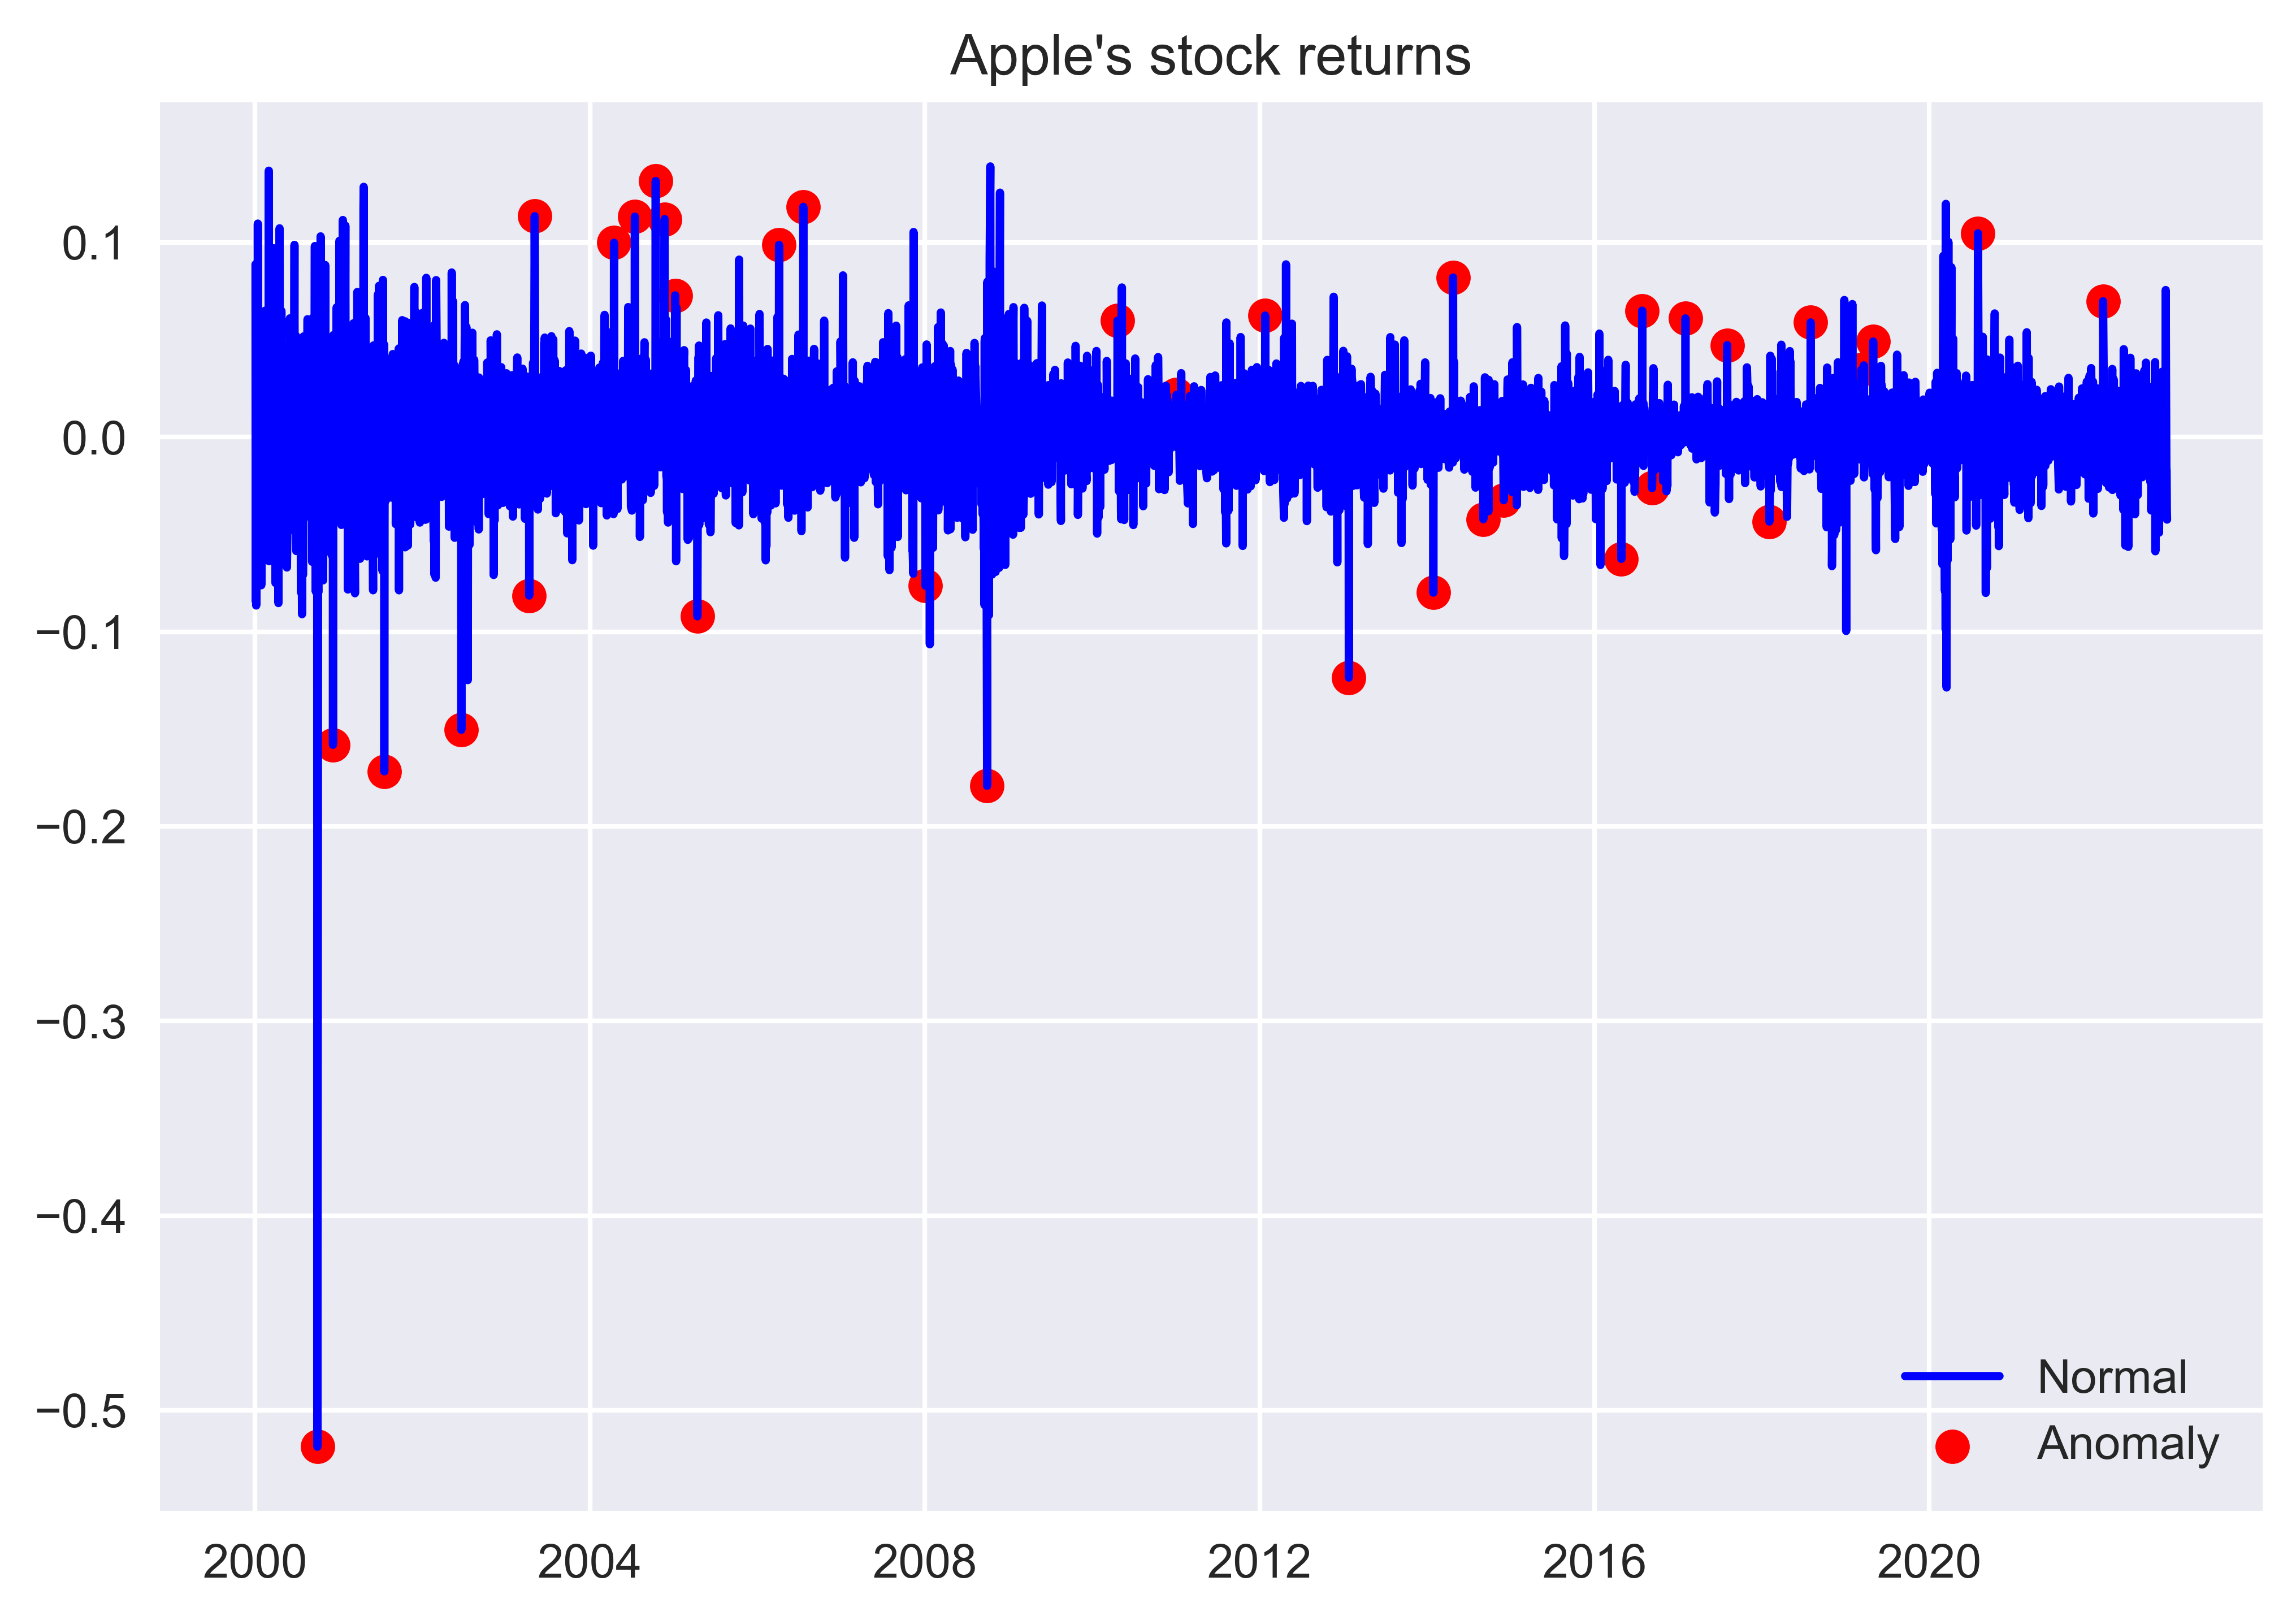

In [25]:
fig, ax = plt.subplots()

ax.plot(df_outliers.index, df_outliers.simple_rtn, color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
ax.set_title("Apple's stock returns")
ax.legend(loc='lower right')
plt.show()

## Investigating stylized facts of asset returns

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [27]:
df = yf.download('^GSPC',
                start='1985-01-01',
                end=datetime.datetime.now().date(),
                progress=False)

df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df.adj_close / df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how='any')

### Fact 1. Non-Gaussian distribution of returns

In [28]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)   # 학습 필요

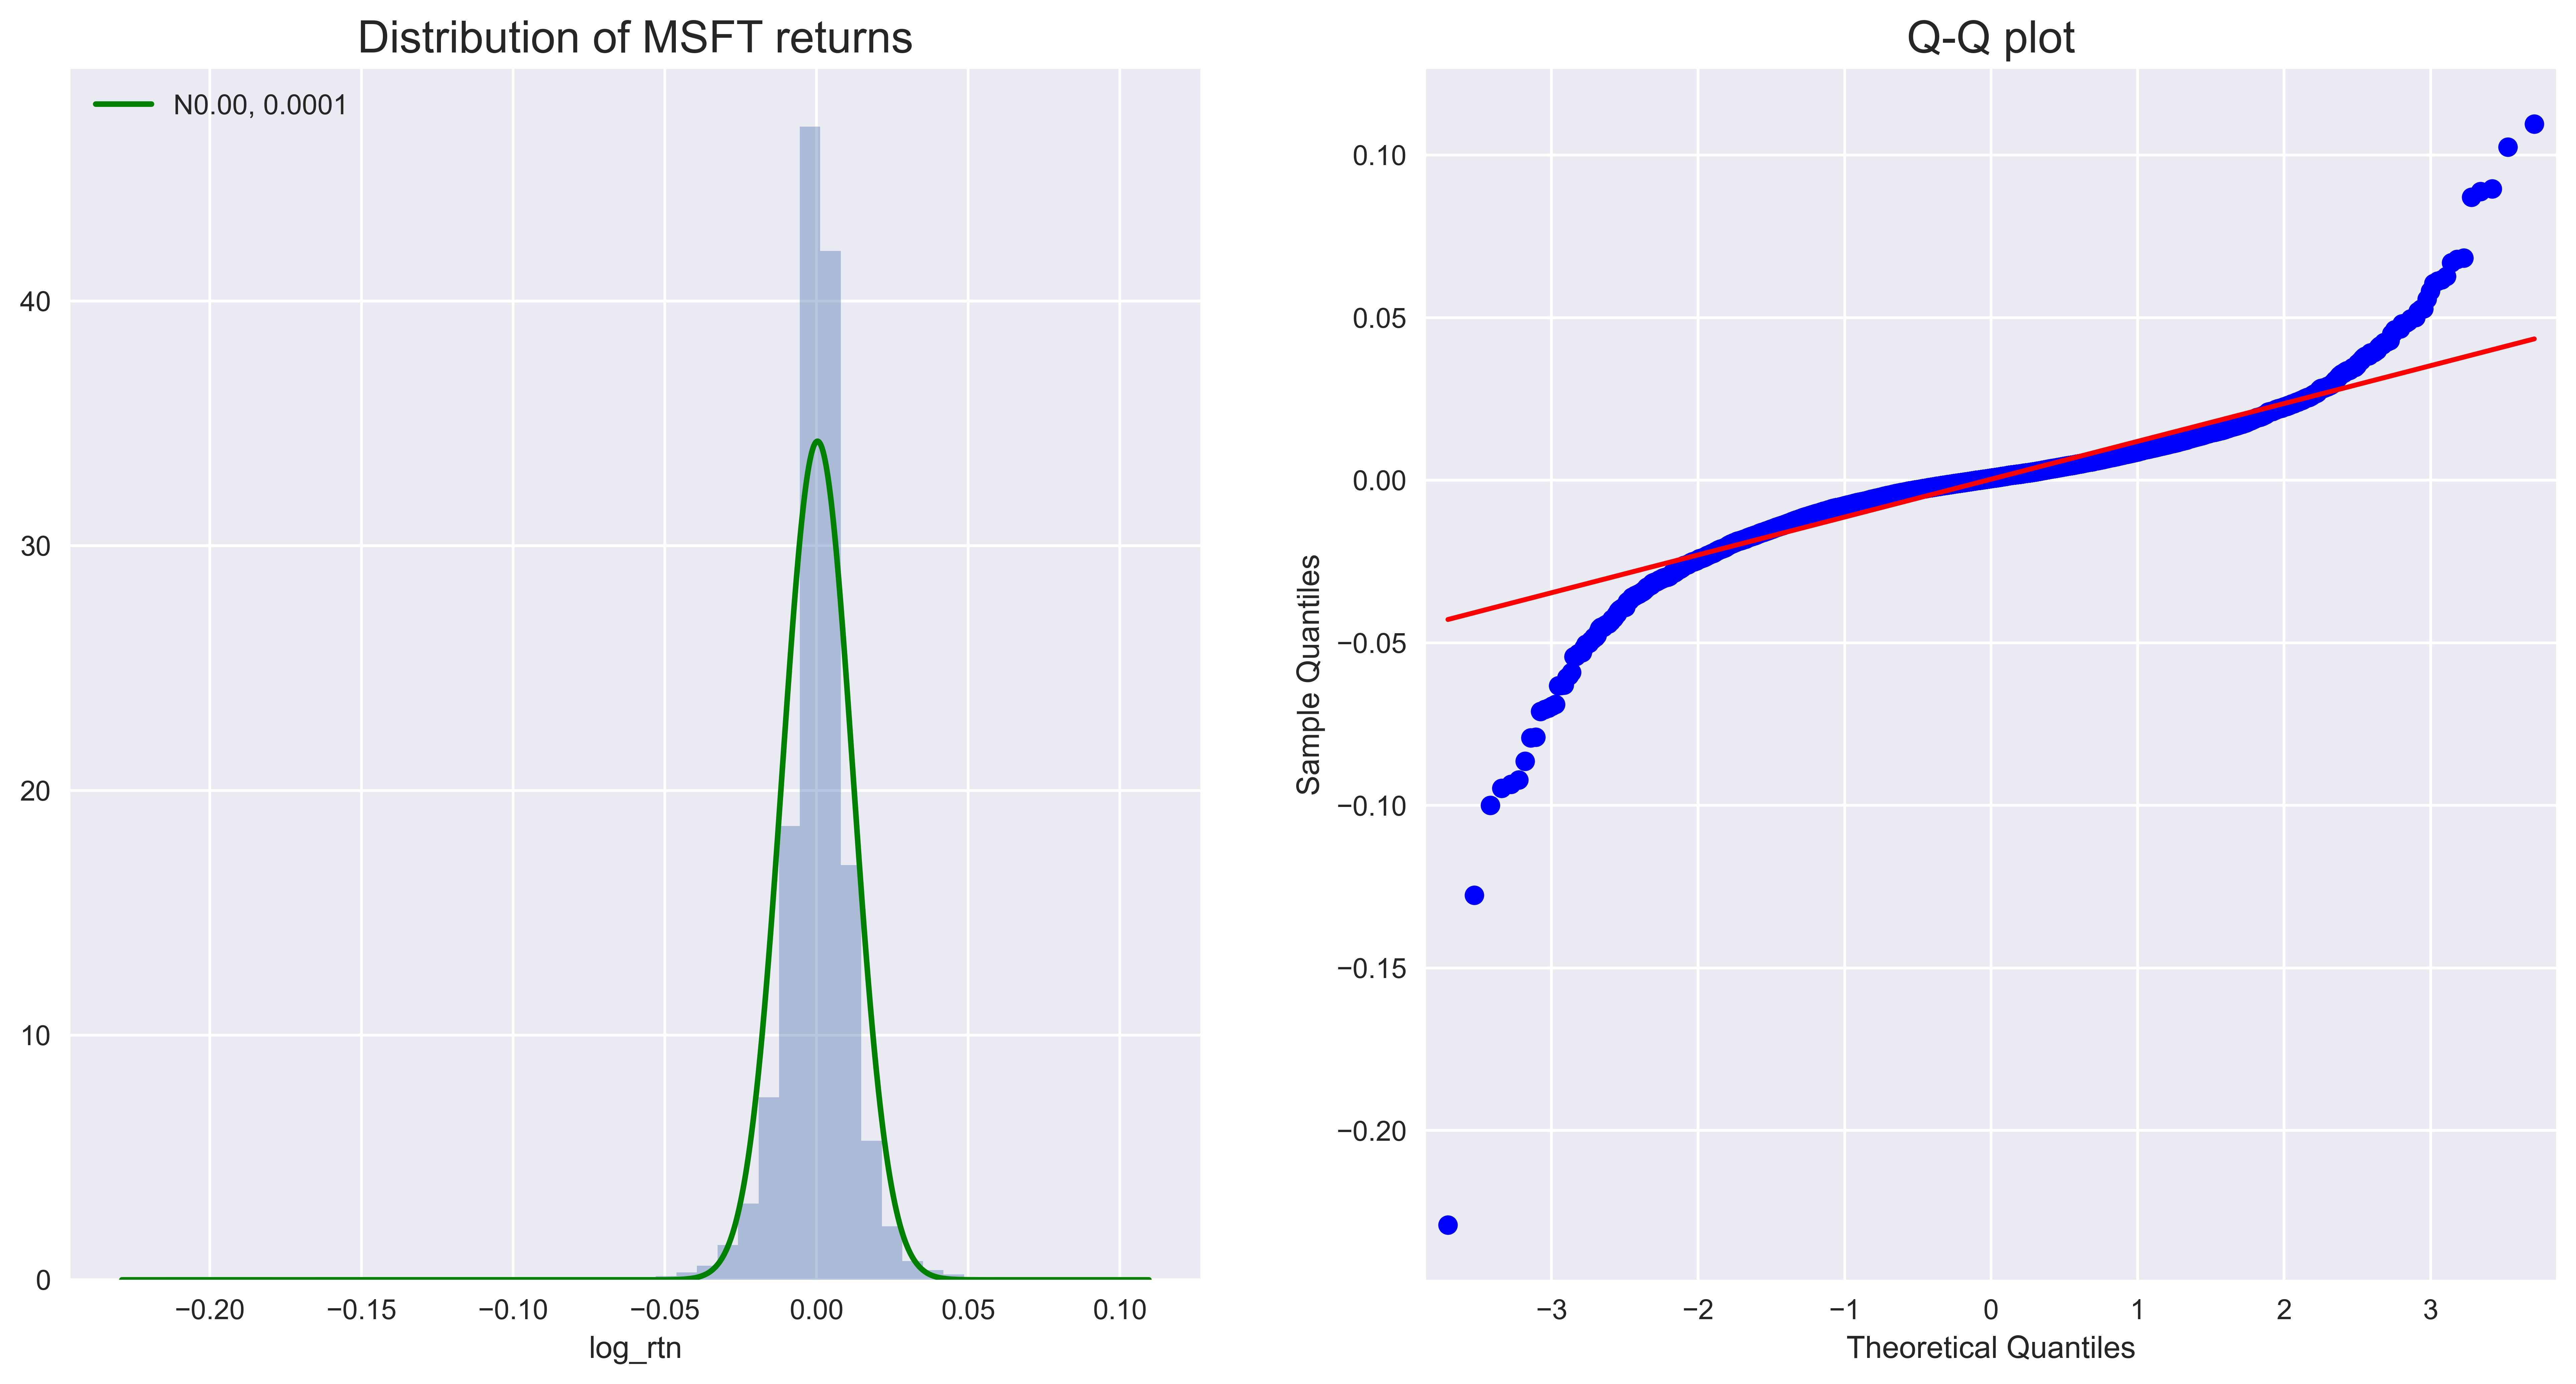

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])   # 학습 필요
ax[0].set_title('Distribution of MSFT returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N{mu:.2f}, {sigma**2:.4f}')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize=16)

# plt.tight_layout()
# plt.savefig('images/ch1_im10.png')
plt.show()

In [33]:
jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates: ', min(df.index.date), '-', max(df.index.date))
print('Number of observations: ', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}')
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates:  1985-01-02 - 2022-11-03
Number of observations:  9539
Mean: 0.0003
Median: 0.0006
Min: -0.2290
Max: 0.1096
Standard Deviation: 0.0116
Skewness: -1.2054
Kurtosis: 25.5110
Jarque-Bera statistic: 260695.81 with p-value: 0.00


### Fact 2 - Volatility Clustering

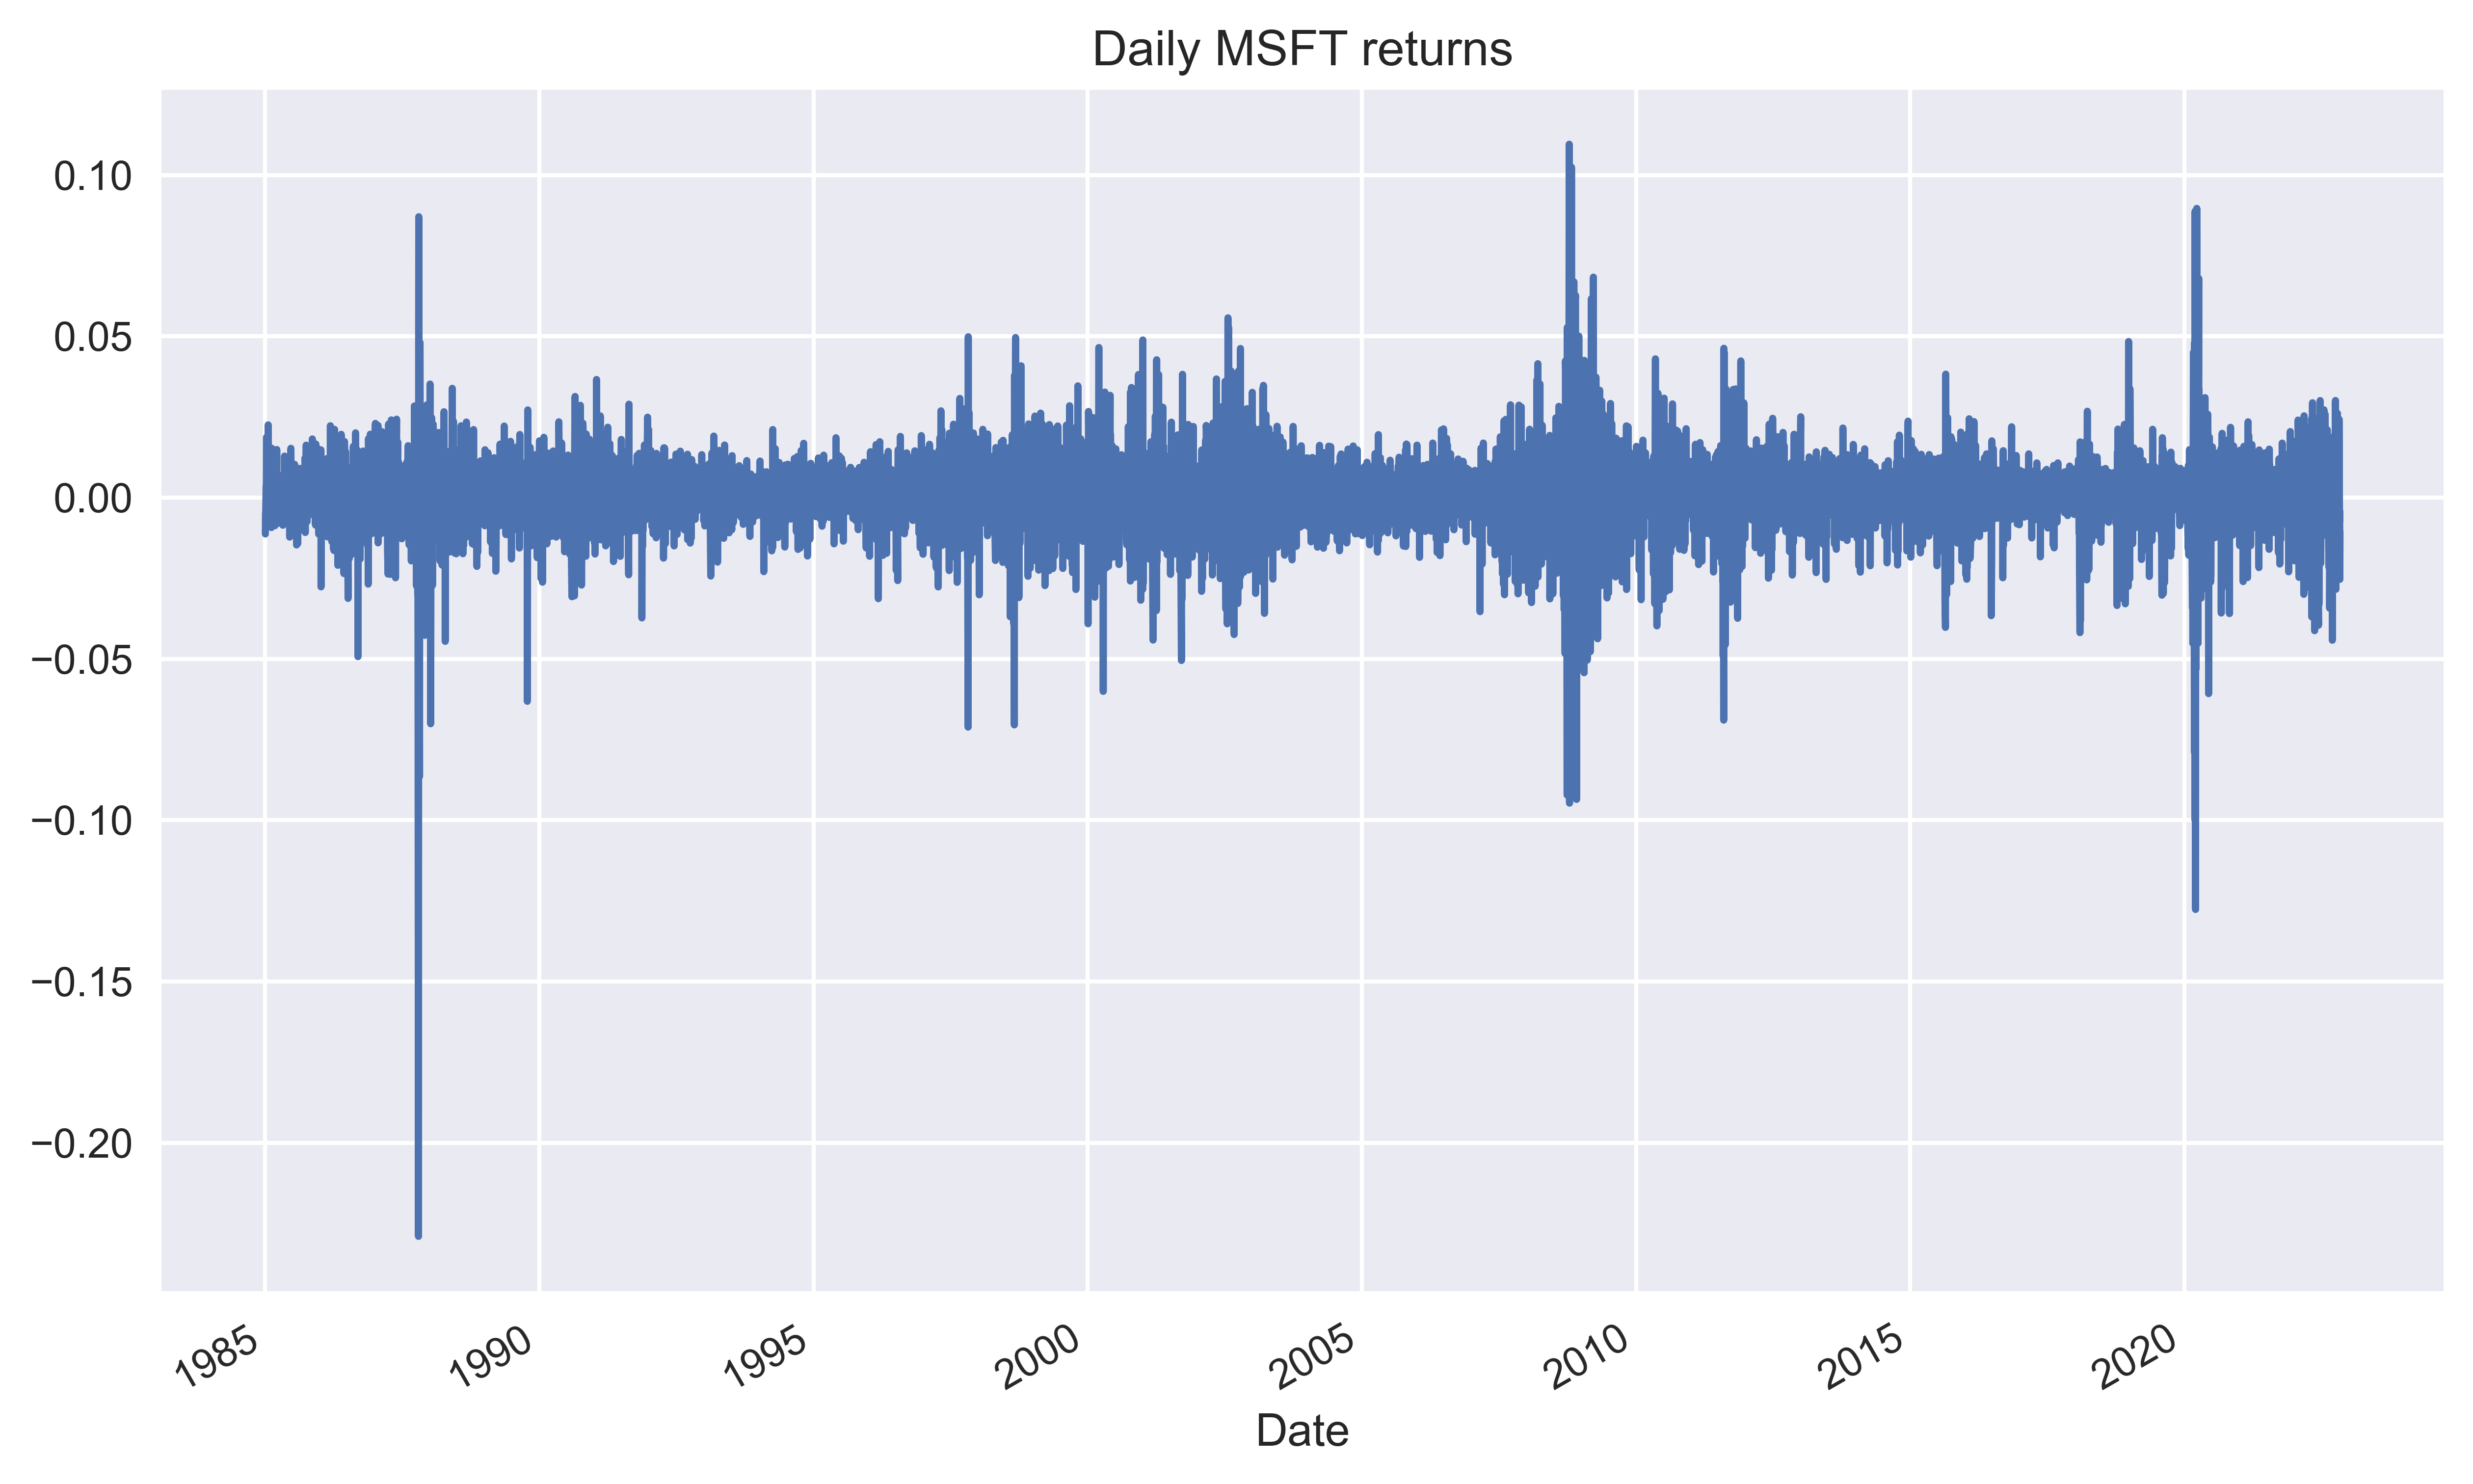

In [34]:
df.log_rtn.plot(title='Daily MSFT returns', figsize=(10, 6))

# plt.tight_layout()
# plt.savefig('images/ch1_im12.png')
plt.show()

### Fact 3 - Absence of autocorrelation in returns

In [35]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

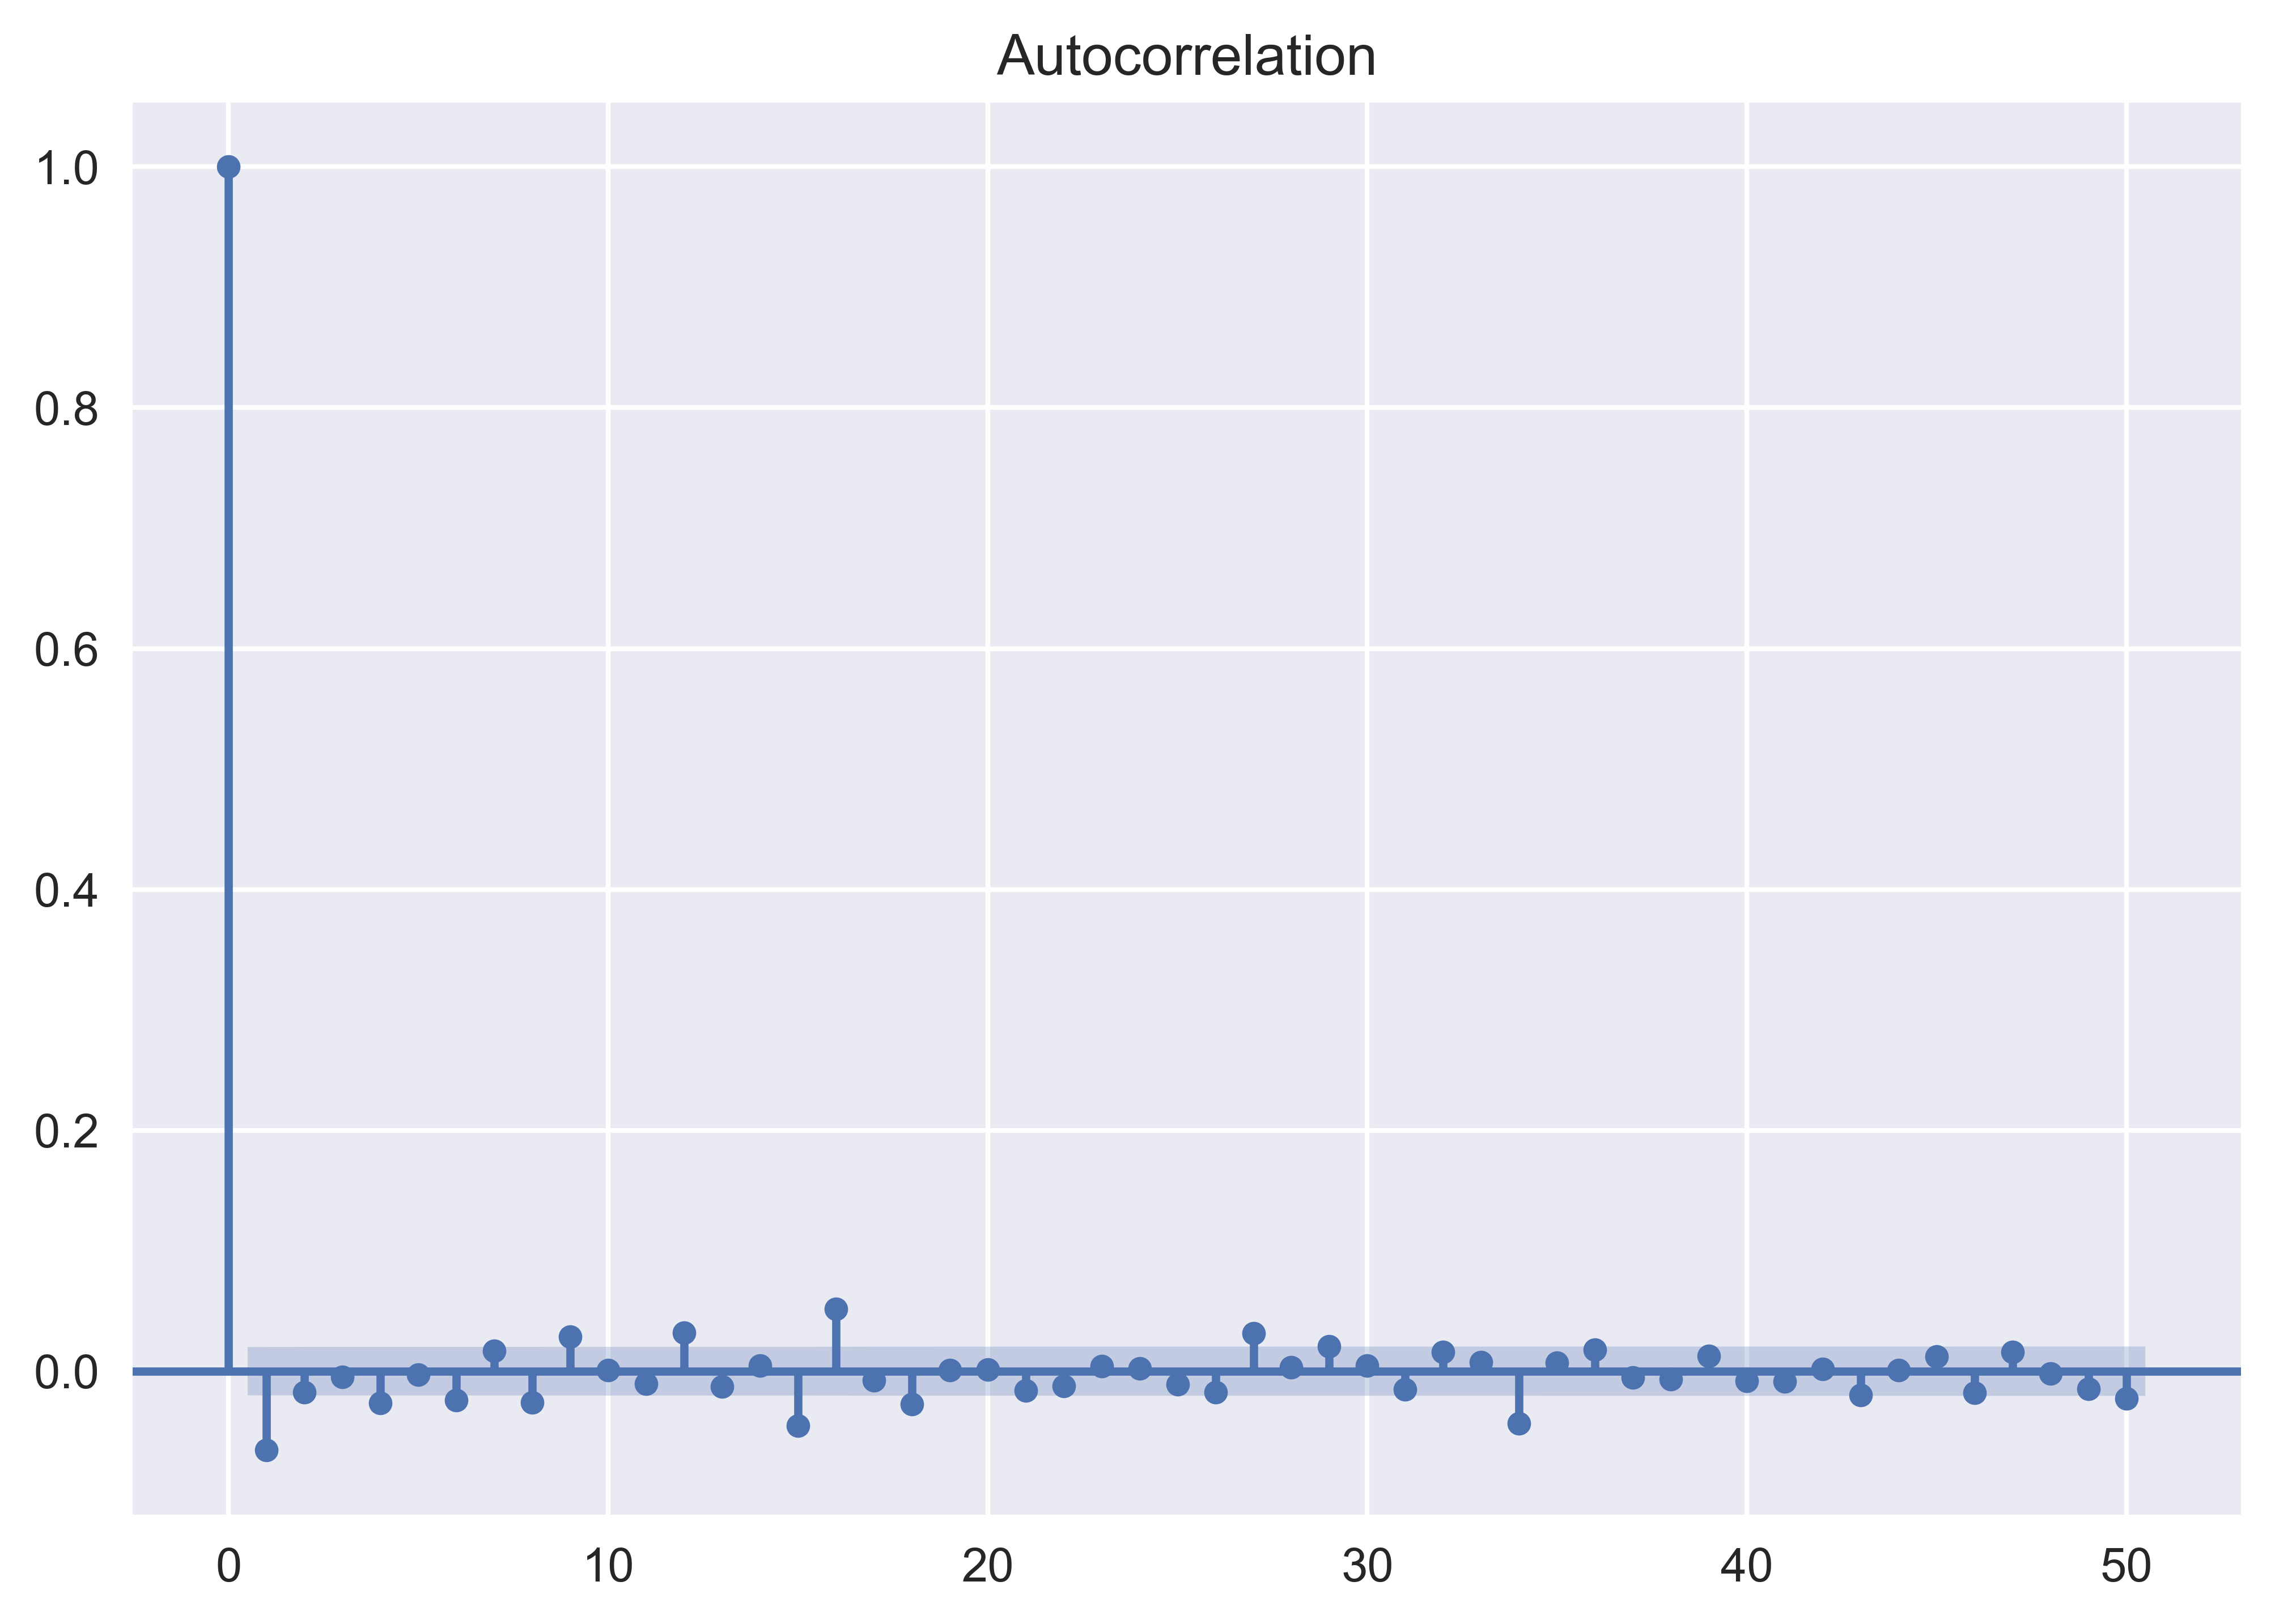

In [36]:
acf = smt.graphics.plot_acf(df.log_rtn,
                           lags=N_LAGS,
                           alpha=SIGNIFICANCE_LEVEL)

# plt.tight_layout()
# plt.savefig('images/ch1_im13.png')
plt.show()